In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from collections import Counter # For counting hashable objects
import math
import os
import pickle
import openpyxl
import warnings
# Suppress warning messages
warnings.filterwarnings("ignore")

In [2]:
#Define the directory for non-flavopiridol experiment pickle files
pick2 = r'C:\Users\smahm\Desktop\Courses\Research\EXP\NF'

# Load summary data for March, September, and November experiments
with open(os.path.join(pick2, 'summaryMar.pickle'), 'rb') as handle:
    march = pickle.load(handle)  # Load March data

with open(os.path.join(pick2, 'summarySep.pickle'), 'rb') as handle:
    september = pickle.load(handle)  # Load September data

with open(os.path.join(pick2, 'summaryNov.pickle'), 'rb') as handle:
    november = pickle.load(handle)  # Load November data

# Define the directory for flavopiridol experiment pickle files
pick3 = r'C:\Users\smahm\Desktop\Courses\Research\EXP\FV'

# Load summary data for December, January, and August experiments
with open(os.path.join(pick3, 'summaryDec.pickle'), 'rb') as handle:
    december = pickle.load(handle)  # Load December data

with open(os.path.join(pick3, 'summaryJan.pickle'), 'rb') as handle:
    january = pickle.load(handle)  # Load January data

with open(os.path.join(pick3, 'summaryAug.pickle'), 'rb') as handle:
    august = pickle.load(handle)  # Load August data

In [3]:
# Function to find the occurrence of nascent mRNA at a given time point in a dictionary
def nas_freq(mytime, mydict):
    """
    Computes the frequency of active alleles for a specified time point.
    
    Input:
    - mytime: Integer representing the time point for which to compute the frequency.
    - mydict: Dictionary containing the results of image processing.

    Output:
    - Numpy array of nascent mRNA occurrences.
    """
    # List to store indices of relevant keys
    occurrence_indices = []
    
    # Iterate through dictionary keys to find relevant entries
    for i, name in enumerate(mydict.keys()):
        # if(("time"+str(mytime)+"field") in name):
        if f"time{mytime}field" in name:
            occurrence_indices.append(i)
    
    # List to store the counts of nascent mRNA
    nascent_counts = []
    
    # Iterate through relevant indices to extract nascent mRNA data
    for idx in occurrence_indices:
        # Get the specific entry from the dictionary
        entry = mydict[list(mydict.keys())[idx]]
        num_nuclei = len(entry)  # Number of nuclei in this entry
        
        for f in range(num_nuclei):
            # Construct the key for nascent mRNA
            nuc_key = f'nuc{f + 1}'
            if nuc_key in entry:
                nascent_counts.append(entry[nuc_key]['Nnascent'])  # Add the count to the list
                
    return np.array(nascent_counts)  # Convert list to a numpy array and return

# Function to get the occurrence or frequency table of nascent mRNA in a given dictionary
def table_occur(mydict, freq=False, tmin=0, tmax=135):
    """
    Computes a table of frequency (occurrence) of active alleles for all time points.
    
    Input:
    - tmin: Integer representing the first time point of the table.
    - tmax: Integer representing the last time point of the table.
    - mydict: Dictionary containing the results of image processing.
    - freq: Boolean indicating whether to return frequencies or counts of active alleles.

    Output:
    - DataFrame containing the table of Qis, possibly with more than 5 rows.
    """
    # Initialize an empty DataFrame for the results
    df = pd.DataFrame()

    # Iterate over time points in the specified range
    for t in range(tmin, tmax, 15):
        # Compute occurrences and create a DataFrame for the current time point
        current_counts = Counter(nas_freq(t, mydict))
        current_df = pd.DataFrame.from_dict(current_counts, orient='index', columns=[t])
        
        # Concatenate the current DataFrame to the results DataFrame
        df = pd.concat([df, current_df], axis=1, sort=True)
    
    # Fill NaN values with 0 and convert to integers
    df = df.fillna(0).astype(int)

    # Return the DataFrame based on the frequency flag
    if freq:
        return (df / df.sum()).round(2)  # Return frequency table
    else:
        return df  # Return count table

In [9]:
# Function to compute the frequency (occurrence) of active alleles
# restricted to a maximum of 4 active alleles
def fourrows(mydict, freq=True, tmin=0, tmax=135):
    """
    Computes a frequency table of active alleles for all time points,
    restricted to a maximum of 4 active alleles.
    
    Input:
    - mydict: Dictionary containing the results of image processing.
    - freq: Boolean indicating whether to return frequency or counts.
    - tmin: Integer representing the first time point.
    - tmax: Integer representing the last time point.

    Output:
    - DataFrame of Qis restricted to nuclei with a maximum of 4 active alleles.
    """
    # Get the occurrence table for the specified time range
    df = table_occur(mydict, tmin=tmin, tmax=tmax)
    newdf = df[0:5]  # Restrict to the first 5 rows
    
    # Calculate frequencies if requested
    if freq:
        newdf = (newdf / newdf.sum()).astype(float).round(2)
        for i in newdf.columns:
            newdf[i][4] = 1 - newdf[i][0:4].sum()  # Calculate the remaining probability
        return newdf.astype(float).round(2)
    
    return newdf  # Return the counts if freq is False

# Function to find the occurrence of nascent mRNA for a specific time point
def nas_freq_aug(myti, mydict, dosage=10):
    """
    Computes the occurrence of nascent mRNA based on the specified time point
    and dosage.

    Input:
    - myti: Integer representing the time point.
    - mydict: Dictionary containing the results of image processing.
    - dosage: Integer representing the dosage (default is 10).

    Output:
    - Numpy array of nascent mRNA occurrences.
    """
    # Map time points to specific string identifiers based on dosage
    time_mapping = {
        90: {10: '01', 100: '12', 1: '13'},
        75: {10: '02', 100: '11', 1: '14'},
        60: {10: '03', 100: '10', 1: '15'},
        45: {10: '04', 100: '09', 1: '16'},
        30: {10: '05', 100: '08', 1: '17'},
        15: {10: '06', 100: '07', 1: '18'}
    }
    
    mytime = time_mapping.get(myti, {}).get(dosage, None)
    if mytime is None:
        raise ValueError("Invalid time point or dosage")
    
    # Find the relevant entries in the dictionary for the specified time
    occurrence_indices = [i for i, name in enumerate(mydict.keys()) if f"time{mytime}field" in name]
    
    nascent_counts = []
    
    # Extract nascent mRNA counts for the relevant entries
    for idx in occurrence_indices:
        entry = mydict[list(mydict.keys())[idx]]
        num_nuclei = len(entry)  # Number of nuclei in this entry
        
        for f in range(num_nuclei):
            nuc_key = f'nuc{f + 1}'
            if nuc_key in entry:
                nascent_counts.append(entry[nuc_key]['Nnascent'])  # Add count to the list

    return np.array(nascent_counts)  # Return as a numpy array

# Function to get the occurrence or frequency table for a given dictionary
def table_occur_aug(mydict, freq=False, tmin=0, tmax=135, dosage=10):
    """
    Computes a table of frequency (occurrence) of active alleles for all time points.

    Input:
    - mydict: Dictionary containing the results of image processing.
    - freq: Boolean indicating whether to return frequencies or counts.
    - tmin: Integer representing the first time point.
    - tmax: Integer representing the last time point.
    - dosage: Integer representing the dosage.

    Output:
    - DataFrame containing the table of Qis.
    """
    df = pd.DataFrame()
    
    # Iterate over specified time points
    for t in range(tmin, tmax, 15):
        # Count occurrences of nascent mRNA and create DataFrame for the current time point
        current_counts = Counter(nas_freq_aug(t, mydict, dosage=dosage))
        current_df = pd.DataFrame.from_dict(current_counts, orient='index', columns=[t])
        
        # Concatenate to the results DataFrame
        df = pd.concat([df, current_df], axis=1, sort=True)
    
    df = df.fillna(0).astype(int)  # Fill NaNs and convert to integers
    
    if freq:
        return (df / df.sum()).round(2)  # Return frequency table
    else:
        return df  # Return count table

# Function to compute the frequency table of active alleles with a maximum of 4 active alleles
def fourrows_aug(mydict, freq=True, tmin=0, tmax=135, dosage=10):
    """
    Computes a frequency table of active alleles for all time points,
    restricted to a maximum of 4 active alleles.
    
    Input:
    - mydict: Dictionary containing the results of image processing.
    - freq: Boolean indicating whether to return frequency or counts.
    - tmin: Integer representing the first time point.
    - tmax: Integer representing the last time point.
    - dosage: Integer representing the dosage.

    Output:
    - DataFrame of Qis restricted to nuclei with a maximum of 4 active alleles.
    """
    df = table_occur_aug(mydict, tmin=tmin, tmax=tmax, dosage=dosage)
    newdf = df[0:5]  # Restrict to the first 5 rows
    
    # Calculate frequencies if requested
    if freq:
        newdf = (newdf / newdf.sum()).astype(float).round(2)
        for i in newdf.columns:
            newdf[i][4] = 1 - newdf[i][0:4].sum()  # Calculate the remaining probability
        return newdf.astype(float).round(2)
    
    return newdf  # Return the counts if freq is False


In [5]:
def smooth(mydf):
    """
    Smooths the frequency curves in the provided DataFrame.
    
    Input:
    - mydf: Pandas DataFrame containing frequency data with time as columns and Qis as rows.
    
    Output:
    - newdf: Pandas DataFrame with smoothed frequency values, rounded to two decimal places.
    """
    n = len(mydf.columns)  # Number of time points
    newdf = pd.DataFrame(index=mydf.index, columns=mydf.columns)  # Initialize new DataFrame for smoothed values
    
    for i in range(n):
        if i == 0:  # First column (first time point)
            newdf.iloc[:, i] = (0.75 * mydf.iloc[:, i]) + (0.25 * mydf.iloc[:, i + 1])
        elif i == n - 1:  # Last column (last time point)
            newdf.iloc[:, i] = (0.25 * mydf.iloc[:, i - 1]) + (0.75 * mydf.iloc[:, i])
        else:  # Middle columns
            newdf.iloc[:, i] = (0.25 * mydf.iloc[:, i - 1]) + (0.5 * mydf.iloc[:, i]) + (0.25 * mydf.iloc[:, i + 1])
    
    # Normalize the new DataFrame
    newdf = newdf / newdf.sum()
    return newdf.round(2)  # Return rounded values

def prob_single_allele(newdf):
    """
    Computes the probability of activation for a single allele from the frequency table.
    
    Input:
    - newdf: Pandas DataFrame containing frequency data with 5 rows.
    
    Output:
    - single_allele: Pandas DataFrame with a single row representing the probability of activation for each time point.
    """
    newdf = newdf / newdf.sum()  # Normalize the DataFrame
    single_allele = pd.DataFrame(index=[1], columns=newdf.columns)  # Initialize DataFrame for results
    
    # Calculate probabilities for single alleles
    for i in newdf.columns:
        single_allele[i] = np.round(((newdf[i][1] / 4) + 
                                      (newdf[i][2] / 2) + 
                                      ((3 * newdf[i][3]) / 4) + 
                                      newdf[i][4]), 2)
    return single_allele  # Return DataFrame of single allele probabilities

def JP(df):
    """
    Computes the joint probability of activation for a pair of alleles.
    
    Input:
    - df: Pandas DataFrame containing frequency data with 5 rows.
    
    Output:
    - jp: List of joint probabilities for each time point.
    """
    jp = []  # Initialize list to store joint probabilities
    
    # Calculate joint probabilities for each time point
    for i in df.columns:
        joint_prob = np.round((df[i][2] / 6) + (df[i][3] / 2) + df[i][4], 2)
        jp.append(joint_prob)  # Append to the list
    
    return jp  # Return the list of joint probabilities


In [6]:
def xlogx(df):
    '''
    Extend the function of x * log(x) to handle x = 0.
    
    Input:
    - df: Pandas DataFrame or Series
    
    Output:
    - New DataFrame or list where each element is replaced by 
      x * log(x) if x > 0, or 0 if x = 0.
    '''
    if isinstance(df, pd.DataFrame):  # Check if input is a DataFrame
        newdf = pd.DataFrame(columns=df.columns, index=df.index)  # Initialize new DataFrame
        for i in range(newdf.shape[0]):  # Iterate over rows
            for j in range(newdf.shape[1]):  # Iterate over columns
                if df.iloc[i, j] == 0:  # Handle case where value is 0
                    newdf.iloc[i, j] = 0
                else:  # Compute x * log(x) for positive values
                    newdf.iloc[i, j] = df.iloc[i, j] * np.log(df.iloc[i, j])
        return newdf
    elif isinstance(df, pd.Series):  # Check if input is a Series
        newdf = []  # Initialize a list for results
        for i in df:
            if i == 0:  # Handle case where value is 0
                newdf.append(0)
            elif i > 0:  # Compute x * log(x) for positive values
                newdf.append(i * np.log(i))
        return newdf
            
def mutualinfo(df):
    '''
    Compute the mutual information from a table of frequency.
    
    Input:
    - df: Table of frequency (Pandas DataFrame with 5 rows)
    
    Output:
    - mutual: List of mutual information values for each column (numpy array)
    '''
    mutual = []  # Initialize a list to store mutual information values
    for i in df.columns:  # Iterate over each column
        R = pd.DataFrame(columns=np.arange(2), index=np.arange(2))  # Initialize a 2x2 DataFrame for probabilities
        R.iloc[0, 0] = df[i][0] + (df[i][1] / 2) + (df[i][2] / 6)  # Compute probabilities for cell (0,0)
        R.iloc[0, 1] = (df[i][1] / 4) + (df[i][2] / 3) + (df[i][3] / 4)  # Compute for cell (0,1)
        R.iloc[1, 0] = R.iloc[0, 1]  # Symmetric entry for (1,0)
        R.iloc[1, 1] = (df[i][2] / 6) + (df[i][3] / 2) + df[i][4]  # Compute for cell (1,1)
        
        qY = R.sum()  # Total probabilities for Y
        pX = R.T.sum()  # Total probabilities for X
        
        v = xlogx(qY)  # Compute x * log(x) for total probabilities
        hY = -sum(v)  # Compute entropy for Y
        
        w = xlogx(pX)  # Compute x * log(x) for marginal probabilities
        hX = -sum(w)  # Compute entropy for X
        
        r = xlogx(R)  # Compute x * log(x) for joint probabilities
        hXY = -sum(r.sum())  # Compute joint entropy
        
        mut = hX + hY - hXY  # Calculate mutual information
        mutual.append(np.round(mut, 2))  # Append rounded mutual information value to the list
    
    return mutual  # Return the list of mutual information values


In [10]:
'''
Table of Qi's for all experiments
'''

# Calculate Qi's for the March experiment, covering time points from 0 to 135
MAR = fourrows(march, tmin=0, tmax=135)

# Calculate Qi's for the September experiment, covering time points from 0 to 135
SEP = fourrows(september, tmin=0, tmax=135)

# Calculate Qi's for the November experiment, covering time points from 15 to 105
NOV = fourrows(november, tmin=15, tmax=105)

# Calculate Qi's for the December experiment, covering time points from 0 to 105
DEC = fourrows(december, tmin=0, tmax=105)

# Calculate Qi's for the January experiment, covering time points from 0 to 105
JAN = fourrows(january, tmin=0, tmax=105)

# Calculate Qi's for the August experiment, covering time points from 15 to 105
# with a dosage of 10
AUG = fourrows_aug(august, tmin=15, tmax=105, dosage=10)


In [11]:
'''
Probability of activation for all experiments
'''

# Calculate the probability of activation for single alleles in the December experiment
PDEC = prob_single_allele(smooth(DEC))

# Calculate the probability of activation for single alleles in the January experiment
PJAN = prob_single_allele(smooth(JAN))

# Calculate the probability of activation for single alleles in the August experiment
PAUG = prob_single_allele(smooth(AUG))

# Calculate the probability of activation for single alleles in the March experiment
PMAR = prob_single_allele(smooth(MAR))

# Calculate the probability of activation for single alleles in the September experiment
PSEP = prob_single_allele(smooth(SEP))

# Calculate the probability of activation for single alleles in the November experiment
PNOV = prob_single_allele(smooth(NOV))


In [12]:
'''
Square of Probability of activation for all experiments
'''

# Calculate the square of the probability of activation for the March experiment
SPMAR = (PMAR.iloc[0, 1:7]) ** 2

# Calculate the square of the probability of activation for the September experiment
SPSEP = (PSEP.iloc[0, 1:7]) ** 2

# Calculate the square of the probability of activation for the November experiment
SPNOV = (PNOV.iloc[0, 0:6]) ** 2

# Calculate the square of the probability of activation for the December experiment
SPDEC = (PDEC.iloc[0, 1:7]) ** 2

# Calculate the square of the probability of activation for the January experiment
SPJAN = (PJAN.iloc[0, 1:7]) ** 2

# Calculate the square of the probability of activation for the August experiment
SPAUG = (PAUG.iloc[0, 0:6]) ** 2


In [13]:
'''
Mutual information for all experiments
'''

# Compute the mutual information for the March experiment
FMAR = mutualinfo(MAR)

# Compute the mutual information for the September experiment
FSEP = mutualinfo(SEP)

# Compute the mutual information for the November experiment
FNOV = mutualinfo(NOV)

# Compute the mutual information for the December experiment
FDEC = mutualinfo(DEC)

# Compute the mutual information for the January experiment
FJAN = mutualinfo(JAN)

# Compute the mutual information for the August experiment
FAUG = mutualinfo(AUG)


In [14]:
'''
Joint probability of activation for all experiments
'''

# Compute the joint probability of activation for the March experiment
JMAR = JP(MAR)

# Compute the joint probability of activation for the September experiment
JSEP = JP(SEP)

# Compute the joint probability of activation for the November experiment
JNOV = JP(NOV)

# Compute the joint probability of activation for the December experiment
JDEC = JP(DEC)

# Compute the joint probability of activation for the January experiment
JJAN = JP(JAN)

# Compute the joint probability of activation for the August experiment
JAUG = JP(AUG)


In [15]:
'''
Time points for the experiments
'''

# List of specific time points for the experiments (in minutes)
myt = [15, 30, 45, 60, 75, 90]

# Extended list of time points, starting from 0 and including the specified points
myt2 = [0, 15, 30, 45, 60, 75, 90]

# List of time points as strings, ranging from 15 to 90 in increments of 15
myt3 = [str(i) for i in range(15, 105, 15)]


In [18]:
'''
Calculating the mean and standard deviation (SD) of Qi values for all experiments.
'''

# Initialize lists to store means and standard deviations for each Qi category
mean_NF = {0: [], 1: [], 2: [], 3: [], 4: []}
sd_NF = {0: [], 1: [], 2: [], 3: [], 4: []}
mean_FV = {0: [], 1: [], 2: [], 3: [], 4: []}
sd_FV = {0: [], 1: [], 2: [], 3: [], 4: []}

# Loop through each Qi category (0 to 4)
for i in range(6):
    # Calculate means and standard deviations for non-flavopiridol (NF) conditions
    for j in range(5):  # For Qi categories 0 to 4
        mean_NF[j].append(np.round(np.mean([MAR.iloc[j, i+1], SEP.iloc[j, i+1], NOV.iloc[j, i]]), 2))
        sd_NF[j].append(np.round(np.std([MAR.iloc[j, i+1], SEP.iloc[j, i+1], NOV.iloc[j, i]]), 2))
        
        # Calculate means and standard deviations for flavopiridol (FV) conditions
        mean_FV[j].append(np.round(np.mean([DEC.iloc[j, i+1], JAN.iloc[j, i+1], AUG.iloc[j, i]]), 2))
        sd_FV[j].append(np.round(np.std([DEC.iloc[j, i+1], JAN.iloc[j, i+1], AUG.iloc[j, i]]), 2))

# The result is stored in the mean_NF, sd_NF, mean_FV, and sd_FV dictionaries.


# Graphics

# Figure 1B

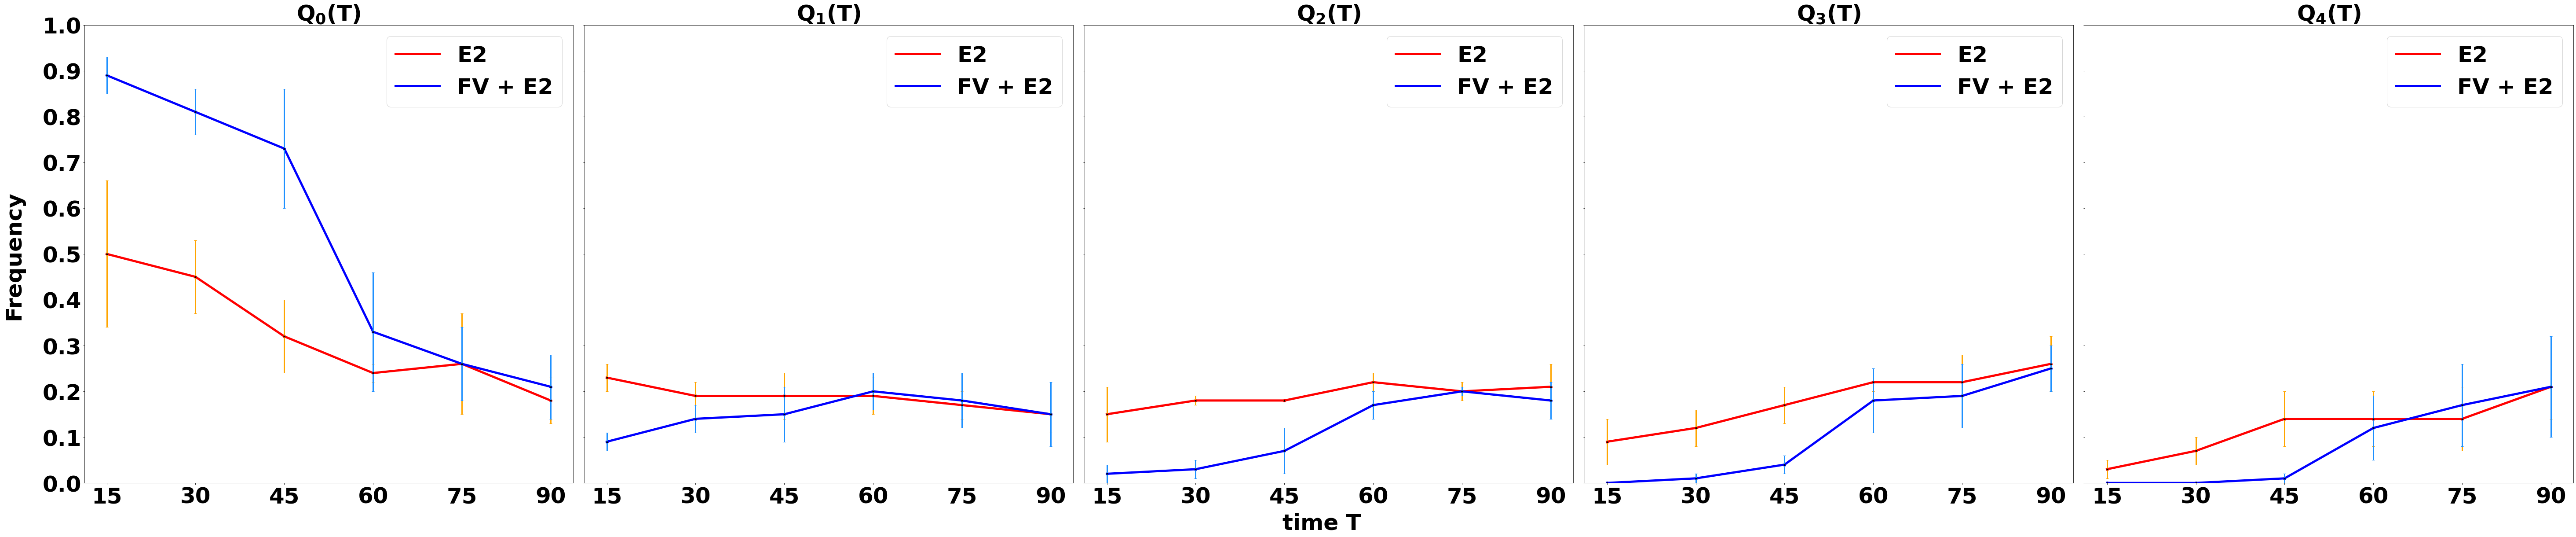

In [19]:
# Define the linewidth for plots
linewidth = 5

# Set plot aesthetics
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', labelsize=30)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(80, 16), constrained_layout=True, sharex=True, sharey=True)

# Prepare y-ticks for the plots
plt.setp(axes, yticks=np.linspace(0, 1, 11, endpoint=True))


# Plotting each Q category
for q in range(5):
    # Plot for non-flavopiridol
    axes[q].plot(myt3, mean_NF[q], color='red', label='E2', linewidth=linewidth)
    axes[q].scatter(myt3, mean_NF[q], color='red')
    axes[q].errorbar(myt3, mean_NF[q], yerr=std_NF[q], fmt='.k', ecolor='orange', elinewidth=3, capsize=3)

    # Plot for flavopiridol
    axes[q].plot(myt3, mean_FV[q], color='blue', label='FV + E2', linewidth=linewidth)
    axes[q].scatter(myt3, mean_FV[q], color='blue')
    axes[q].errorbar(myt3, mean_FV[q], yerr=std_FV[q], fmt='.k', ecolor='dodgerblue', elinewidth=3, capsize=3)

    # Set titles and legends
    axes[q].legend(loc='upper right', prop={'size': 50})
    axes[q].set_title(f"$\mathbf{{Q_{{{q}}}}}$(T)", fontsize=50, fontweight="bold")

# Set tick parameters and axis limits
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=50)

plt.ylim([0, 1])
fig.text(0.49, -0.05, 'time T', ha='left', va='bottom', fontsize=50)  # x label
fig.text(-0.015, 0.5, 'Frequency', ha='left', va='center', rotation='vertical', fontsize=50)  # y label

# Show the plot
plt.show()

# Figure 3B

In [ ]:
# Set plot aesthetics for font weight
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Plot the data for mutual information between alleles for E2 (non-flavopiridol) condition
plt.plot(myt3, mean_NF[0], color='red', label='E2', linewidth=4)

# Add error bars for the E2 condition using standard deviations from sd_NF
plt.errorbar(myt3, mean_NF[0], yerr=sd_NF[0], fmt='.k', ecolor='orange', elinewidth=3, capsize=3)

# Plot the data for mutual information between alleles for FV + E2 (flavopiridol) condition
plt.plot(myt3, mean_FV[0], color='blue', label='FV + E2', linewidth=4)

# Add error bars for the FV + E2 condition using standard deviations from sd_FV
plt.errorbar(myt3, mean_FV[0], yerr=sd_FV[0], fmt='.k', ecolor='dodgerblue', elinewidth=3, capsize=3)

# Set the y-axis limits
plt.ylim([0, 0.15])

# Add the legend to the plot
plt.legend(loc='upper right', prop={'size': 22})

# Set the labels for x and y axes
plt.ylabel("Mutinf(T)", size=25)
plt.xlabel("time T", size=25)

# Add the plot title with proper formatting
plt.title("Mutual Information between alleles $\mathbf{AL_{1}}$ and $\mathbf{AL_{2}}$", fontweight="bold", fontsize=22)

# Display the plot
plt.show()


# Figure 3C

In [ ]:
# Set font weight and label weight for the plot
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15), constrained_layout=False, sharex=True, sharey=True)

# Add the title to the figure
fig.suptitle('Comparison of $\mathbf{P_{AL_{1}AL_{2}}}$(T) and $\mathbf{P_{AL_{1}}}$(T) $* \mathbf{P_{AL_{2}}}$(T)', 
             y=1, fontweight="bold", fontsize=50)

# Set common y-axis tick marks
plt.setp(axes, yticks=np.linspace(0, 1, 11, endpoint=True))

# Plot for E2 (non-flavopiridol) condition
axes[0].plot(myt3, mean_NF[0], color='red', label='$\mathbf{P_{AL_{1}}}$(T)*$\mathbf{P_{AL_{2}}}$(T) of E2', linewidth=4)
axes[0].errorbar(myt3, mean_NF[0], yerr=sd_NF[0], fmt='.k', ecolor='orange', elinewidth=3, capsize=3)

axes[0].plot(myt3, mean_NF[1], color='green', label='$\mathbf{P_{AL_{1}AL_{2}}}$(T) of E2', linewidth=4)
axes[0].errorbar(myt3, mean_NF[1], yerr=sd_NF[1], fmt='.k', ecolor='lightgreen', elinewidth=3, capsize=3)

# Add legend to the first plot
axes[0].legend(loc='upper left', prop={'size': 30})

# Plot for FV + E2 (flavopiridol) condition
axes[1].plot(myt3, mean_FV[0], color='blue', label='$\mathbf{P_{AL_{1}}}$(T)*$\mathbf{P_{AL_{2}}}$(T) of FV + E2', linewidth=4)
axes[1].errorbar(myt3, mean_FV[0], yerr=sd_FV[0], fmt='.k', ecolor='dodgerblue', elinewidth=3, capsize=3)

axes[1].plot(myt3, mean_FV[1], color='green', label='$\mathbf{P_{AL_{1}AL_{2}}}$(T) of FV + E2', linewidth=4)
axes[1].errorbar(myt3, mean_FV[1], yerr=sd_FV[1], fmt='.k', ecolor='lightgreen', elinewidth=3, capsize=3)

# Add legend to the second plot
axes[1].legend(loc='upper left', prop={'size': 30})

# Adjust the tick parameters for both subplots
for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=40)

# Adjust the layout of the figure
fig.tight_layout()

# Add common x-axis and y-axis labels
fig.text(0.5, -0.01, 'time T', ha='left', va='bottom', fontsize=40)  # X-axis label
fig.text(-0.01, 0.5, 'Probability', ha='left', va='center', rotation='vertical', fontsize=40)  # Y-axis label

# Display the plot
plt.show()


# Figure 3D

In [ ]:
# Set font weight and label weight for the plot
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Title of the plot
plt.title('The ratio of $\mathbf{P_{AL_{1}AL_{2}}}$(T) and $\mathbf{P_{AL_{1}}}$(T)$\mathbf{P_{AL_{2}}}$(T)', 
          fontsize=25, fontweight="bold")

# Plotting the ratio for E2 (non-flavopiridol) condition
plt.plot(myt3, np.divide(mean_NF[1], mean_NF[0]), color='red', label='For E2', linewidth=4)

# Calculate the ratio for FV + E2 condition
FVratio = np.divide(np.array(mean_FV[1]), np.array(mean_FV[0]))

# Setting first two points of FVratio to 0 as done in the original code
FVratio[0] = 0
FVratio[1] = 0

# Plotting the ratio for FV + E2 (flavopiridol) condition
plt.plot(myt3, FVratio, color='blue', label='For FV + E2', linewidth=4)

# Add the legend and customize the appearance
plt.legend(loc='lower right', prop={'size': 25})
plt.tick_params(axis='both', which='major', labelsize=25)

# Axis labels
plt.ylabel("Probability", size=25)
plt.xlabel("Time T", size=25)

# Adjust font size for figure text
plt.rcParams.update({'font.size': 25})

# Show the plot
plt.show()
